# QRT - Electricity: EDA

## Input Data Description

**Identifiers:**

* ID: Unique row identifier, associated with a day (DAY_ID) and a country (COUNTRY),

* DAY_ID: Day identifier - dates have been anonymized, but all data corresponding to a specific day is consistent,

* COUNTRY: Country identifier - DE = Germany, FR = France,

**Daily commodity price variations:**

* GAS_RET: European gas,

* COAL_RET: European coal,

* CARBON_RET: Carbon emissions futures,

**Weather Measures:** (daily, in the country x),

* x_TEMP: Temperature,

* x_RAIN: Rainfall,

* x_WIND: Wind,

**Energy production measures** (daily, in the country x),

* x_GAS: Natural gas,

* x_COAL: Hard coal,

* x_HYDRO: Hydro reservoir,

* x_NUCLEAR: Daily nuclear production,

* x_SOLAR: Photovoltaic,

* x_WINDPOW: Wind power,

* x_LIGNITE: Lignite,

**electricity use metrics** (daily, in the country x),

* x_CONSUMPTON: Total electricity consumption,

* x_RESIDUAL_LOAD: Electricity consumption after using all renewable energies,

* x_NET_IMPORT: Imported electricity from Europe,

* x_NET_EXPORT: Exported electricity to Europe,

* DE_FR_EXCHANGE: Total daily electricity exchange between Germany and France,

* FR_DE_EXCHANGE: Total daily electricity exchange between France and Germany.

# Libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Loading data

- `X_train` and `X_test` both have $35$ columns that represent the same explanatory variables but over different time periods.

- `X_train` and `Y_train` share the same column `ID` - each row corresponds to a unique ID associated wwith a day and a country.

- The target of this challenge `TARGET` in `Y_train` corresponds to the price change for daily futures contracts of 24H electricity baseload.

- **You will notice some columns have missing values**.


In [2]:
# After downloading the X_train/X_test/Y_train .csv files in your working directory:
X_train = pd.read_csv('X_train.csv', index_col='ID')
Y_train = pd.read_csv('Y_train.csv', index_col='ID')
X_test = pd.read_csv('X_test.csv', index_col='ID')
Y_test = pd.read_csv('Y_train.csv', index_col='ID')

X_train.head()

,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
ID,,,,,,,,,,,,,,,,,,,,,
1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,-0.692860,...,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,1.130838,...,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,1.682587,...,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,-0.563230,...,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948
1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,-0.990324,...,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378


In [3]:
Y_train.head()

,TARGET
ID,
1054,0.028313
2049,-0.112516
1924,-0.180840
297,-0.260356
1101,-0.071733


# Exploration

## Training Output (Target)

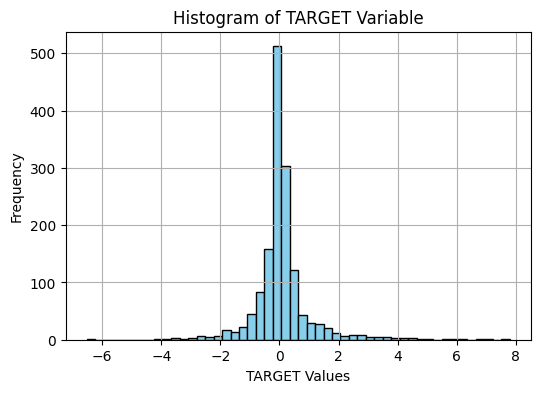

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))  # Adjusting figure size
plt.hist(Y_train.TARGET, bins=50, color='skyblue', edgecolor='black')  # Customizing color and edgecolor
plt.title('Histogram of TARGET Variable')  # Adding title
plt.xlabel('TARGET Values')  # Adding x-axis label
plt.ylabel('Frequency')  # Adding y-axis label
plt.grid(True)  # Adding grid for better readability
plt.show()  # Displaying the plot

## Training Input

### Describe

In [5]:
X_train.describe()

,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
count,1494.000000,1494.000000,1494.000000,1469.000000,1469.000000,1370.000000,1424.000000,1370.000000,1424.000000,1494.000000,...,1494.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1494.000000,1494.000000,1494.000000
mean,591.861446,0.427442,-0.020032,-0.145508,0.145508,-0.256332,-0.072643,0.256332,0.072643,0.780699,...,-0.153688,-0.037831,0.019357,0.109480,0.123099,0.009451,0.008404,0.058126,0.061724,0.080510
std,345.065043,0.673412,0.918995,0.970226,0.970226,0.957443,1.075830,0.957443,1.075830,0.850190,...,0.896325,0.984233,1.051781,1.056243,1.054692,0.972394,1.003356,1.097768,1.033853,1.098624
min,0.000000,-2.265563,-1.462350,-2.856874,-2.634831,-2.464849,-2.825331,-2.279619,-1.951516,-1.117260,...,-1.678936,-2.128531,-1.726420,-1.880419,-1.895319,-4.549638,-5.787097,-5.349463,-5.706442,-4.281790
25%,292.250000,-0.037421,-0.716771,-0.875213,-0.638867,-0.977214,-0.851500,-0.452252,-0.794843,0.134947,...,-0.802333,-0.642117,-0.503927,-0.652135,-0.672614,-0.618259,-0.647948,-0.624238,-0.458038,-0.522968
50%,591.000000,0.357061,-0.394166,-0.164287,0.164287,-0.306899,0.099455,0.306899,-0.099455,0.740006,...,-0.460160,-0.274901,-0.228147,-0.261571,-0.229031,-0.026306,-0.020889,0.008493,0.063312,0.054056
75%,885.750000,0.922057,0.650533,0.638867,0.875213,0.452252,0.794843,0.977214,0.851500,1.399461,...,0.382191,0.335237,0.154351,0.635050,0.824781,0.651832,0.699131,0.676415,0.641446,0.599094
max,1215.000000,2.033851,3.300640,2.634831,2.856874,2.279619,1.951516,2.464849,2.825331,3.118082,...,2.918326,7.756118,9.473201,5.085624,4.965028,2.858758,2.817239,5.674778,3.746576,5.471818


### Null Values


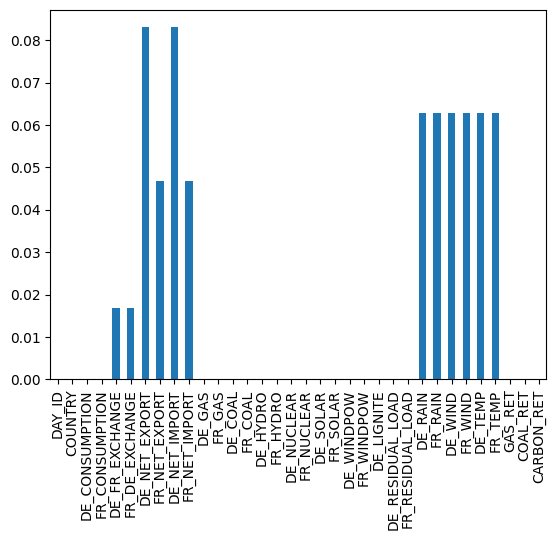

In [6]:
(X_train.isna().sum()/X_train.shape[0]).plot(kind='bar');

* Some features have 6% to 8% missing values

`Note: handle missing values during preprocessing`

### Plot Features Distribution - Overview

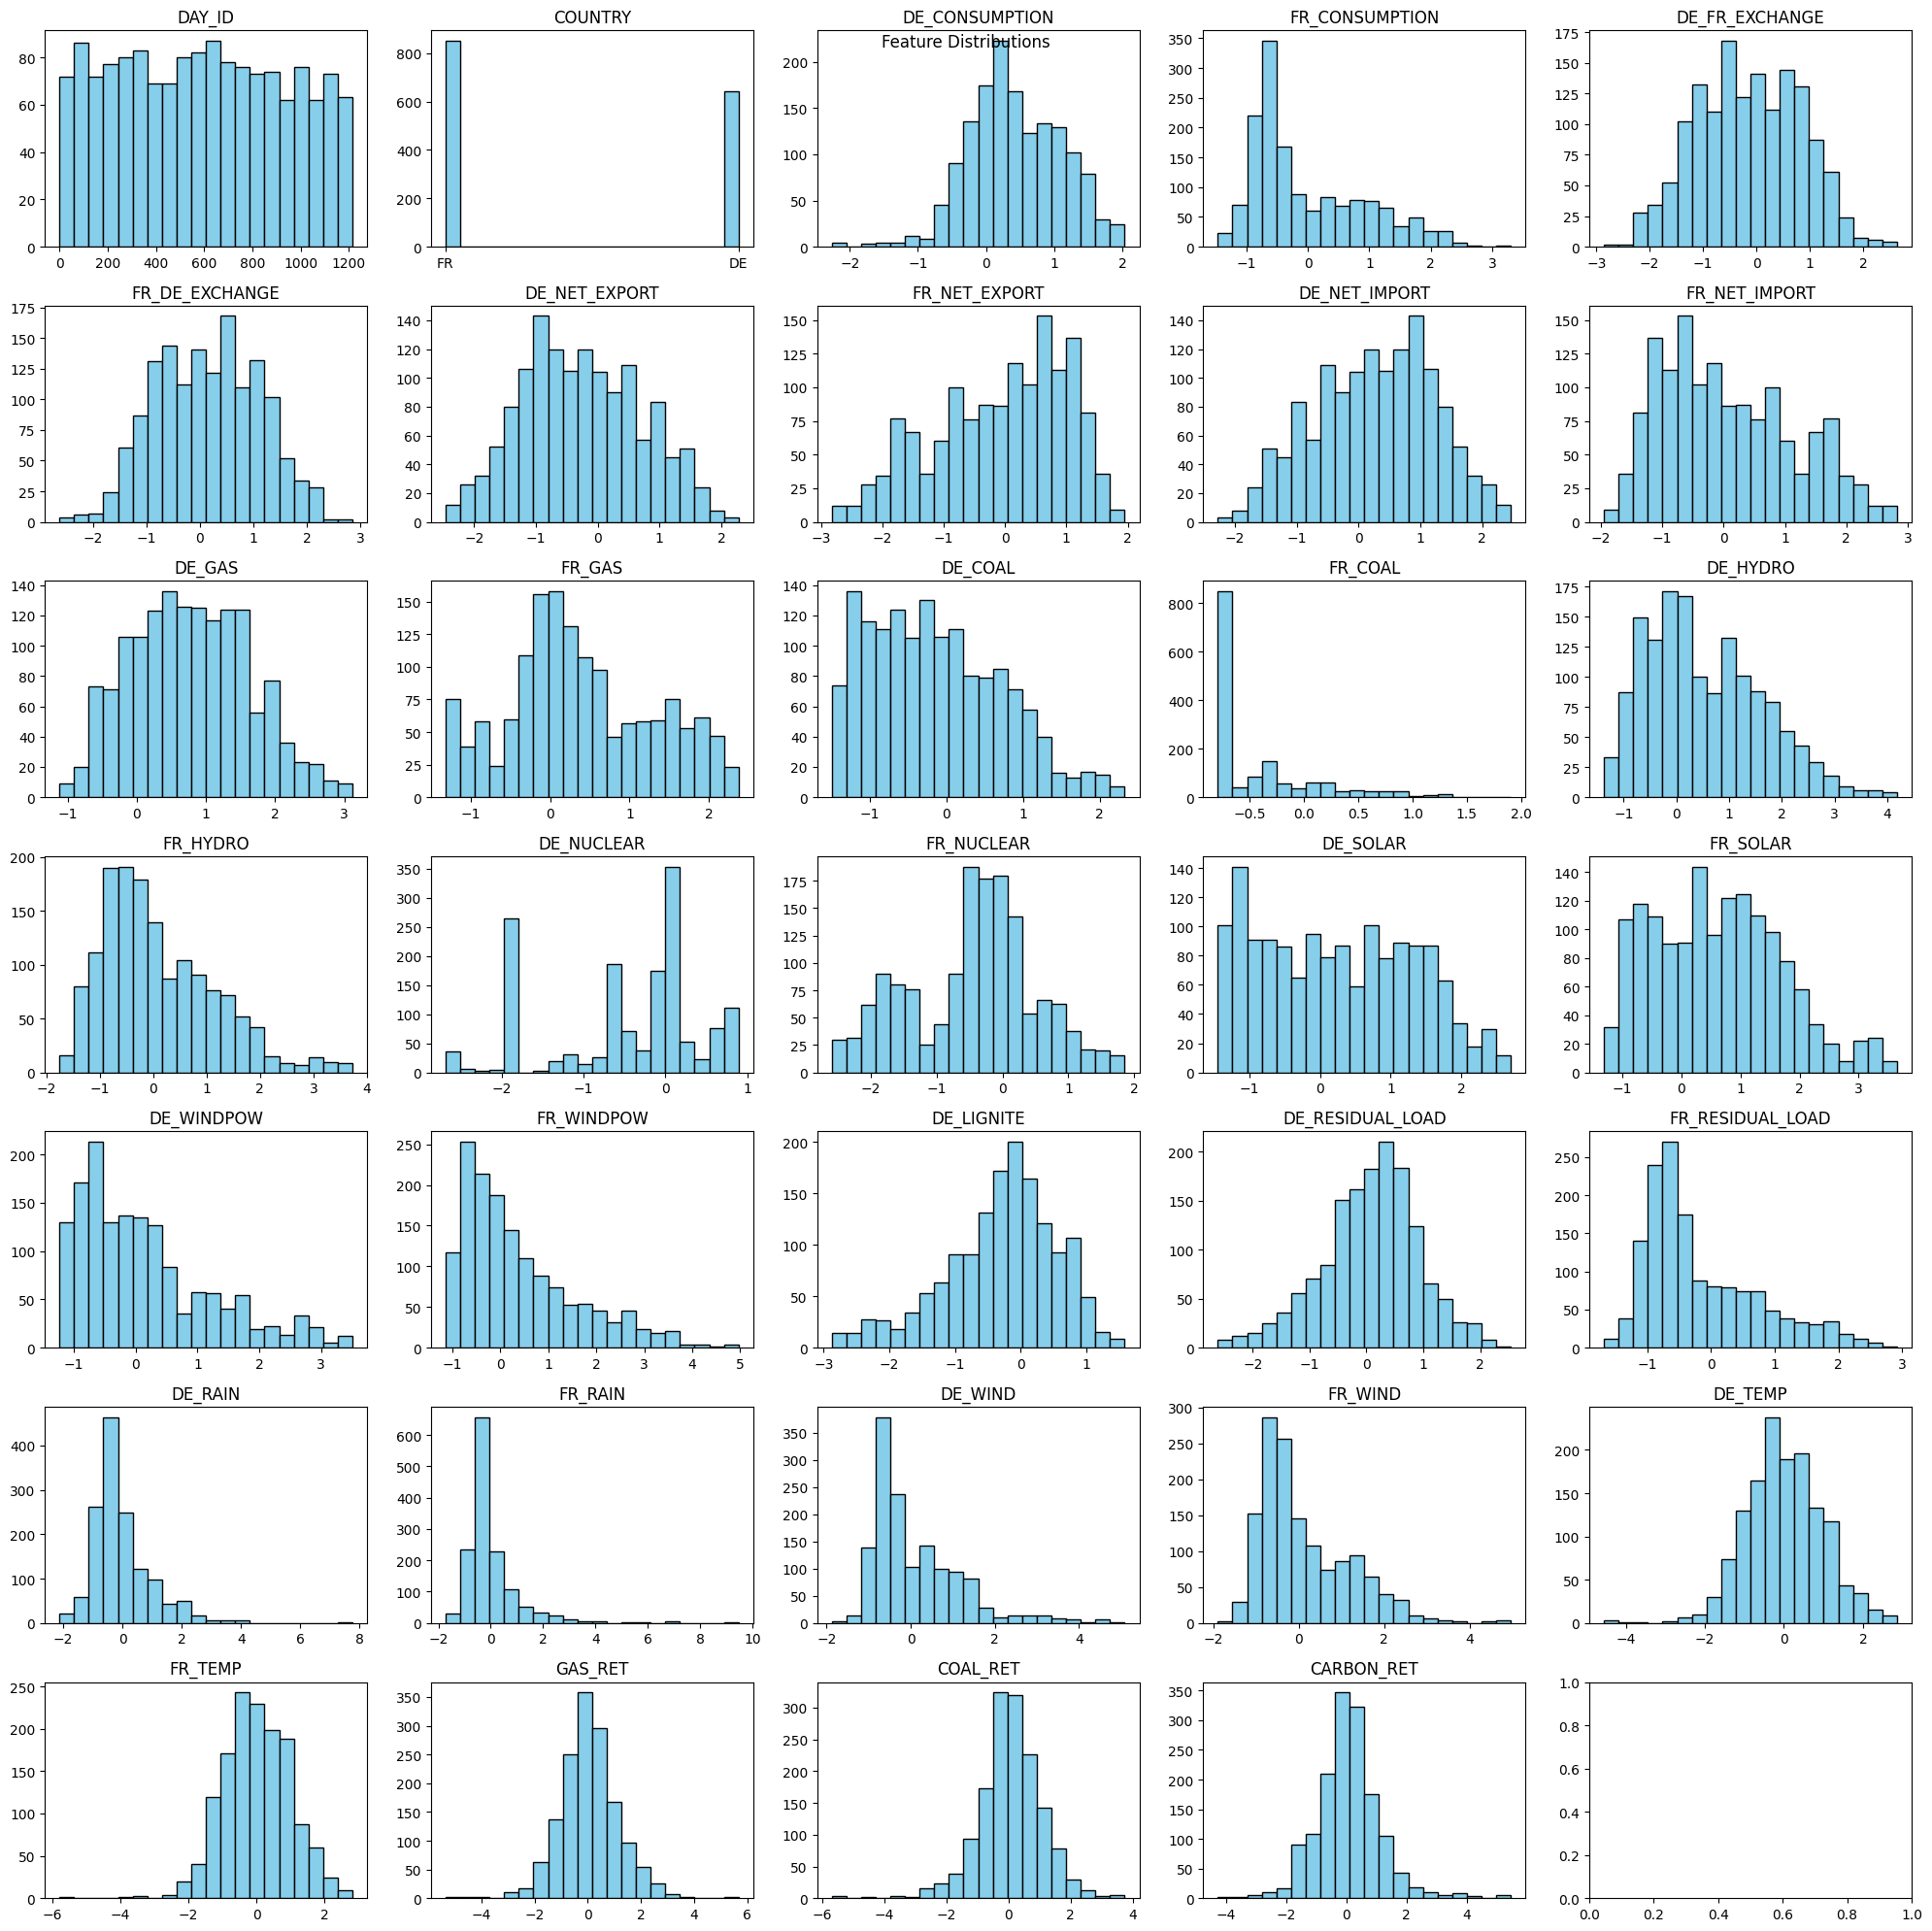

In [7]:
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 20))
axes = axes.flatten()
for i, column in enumerate(X_train.columns):
    ax = axes[i]  # Select the current axis
    ax.hist(X_train[column], bins=20, color='skyblue', edgecolor='black')  # Plot histogram
    ax.set_title(column)  # Set column name as title
plt.tight_layout()
plt.suptitle('Feature Distributions')
plt.show()

### Plot the distribution - DE & FR - Only on Trainset

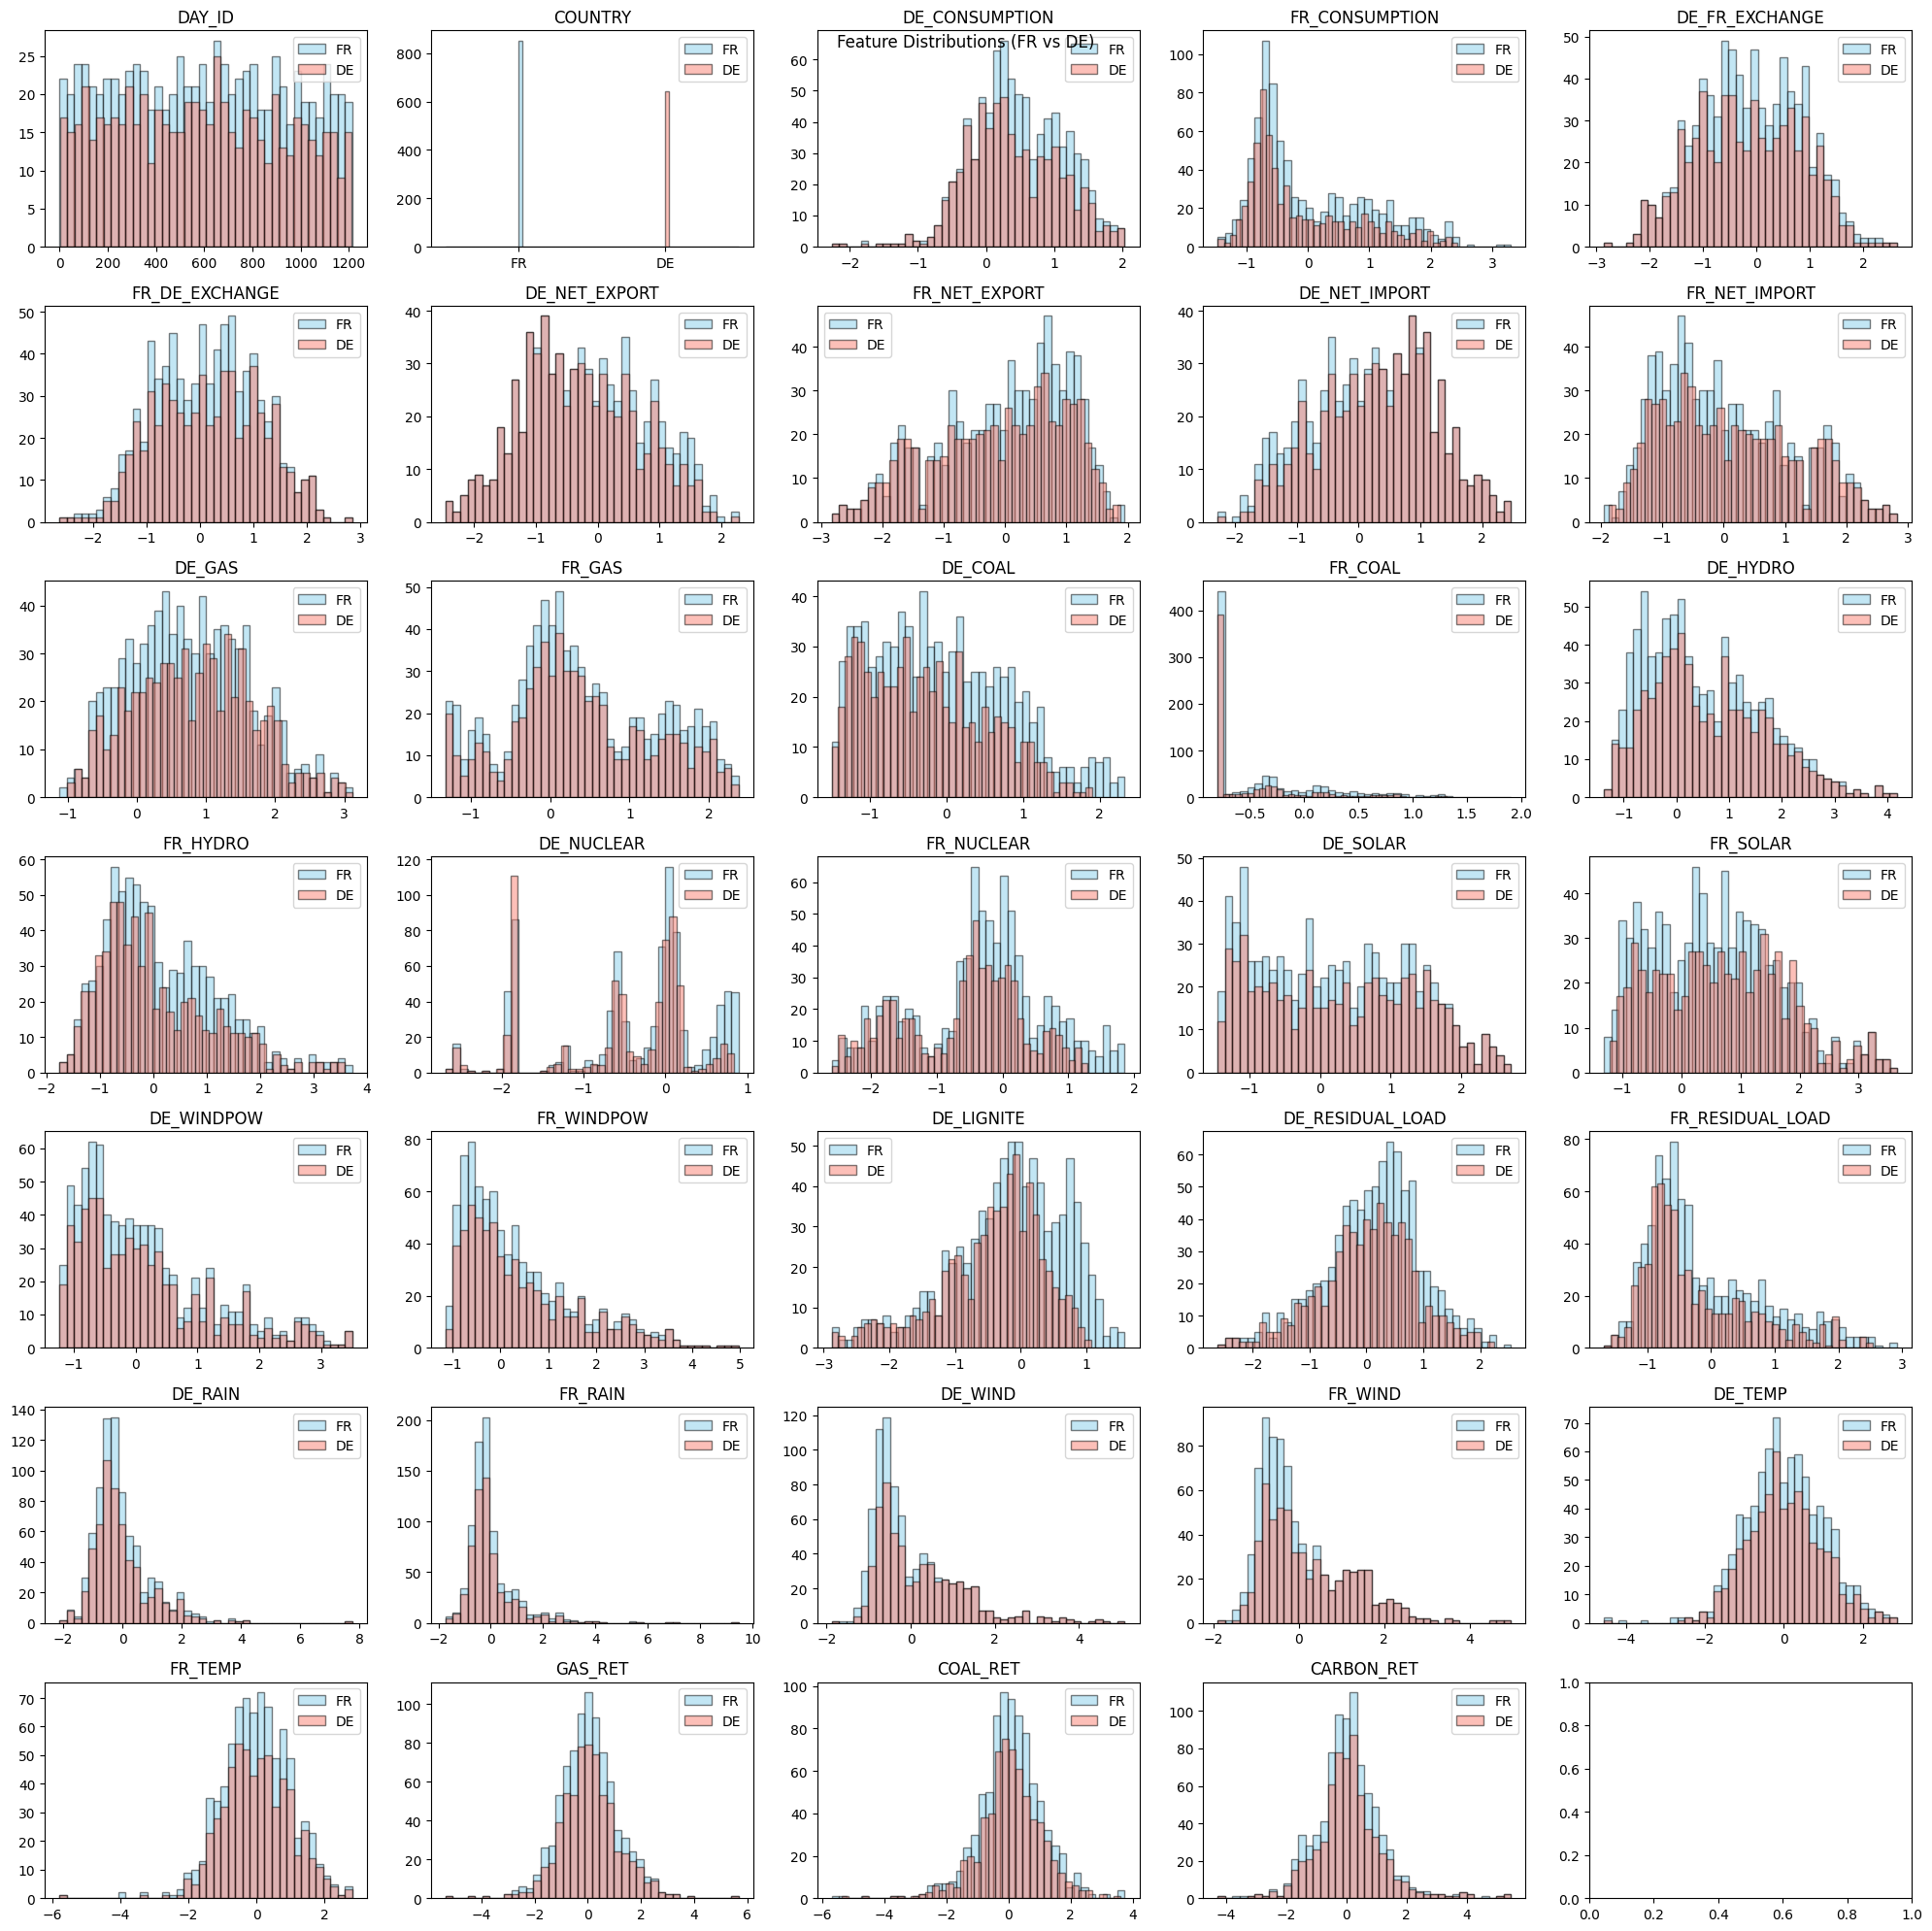

In [11]:
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 20))
axes = axes.flatten()
# Filter dataset based on 'COUNTRY' column values
X_train_FR = X_train[X_train['COUNTRY'] == 'FR']
X_train_DE = X_train[X_train['COUNTRY'] == 'DE']
for i, column in enumerate(X_train.columns):
    ax = axes[i]  # Select the current axis
    # Plot histogram for 'FR'
    ax.hist(X_train_FR[column], bins=40, color='skyblue', edgecolor='black', alpha=0.5, label='FR')
    # Plot histogram for 'DE'
    ax.hist(X_train_DE[column], bins=40, color='salmon', edgecolor='black', alpha=0.5, label='DE')
    ax.set_title(column)  # Set column name as title
    ax.legend()  # Add legend
plt.tight_layout()
plt.suptitle('Feature Distributions (FR vs DE)')
plt.show()

### Plotting Correlations between variables

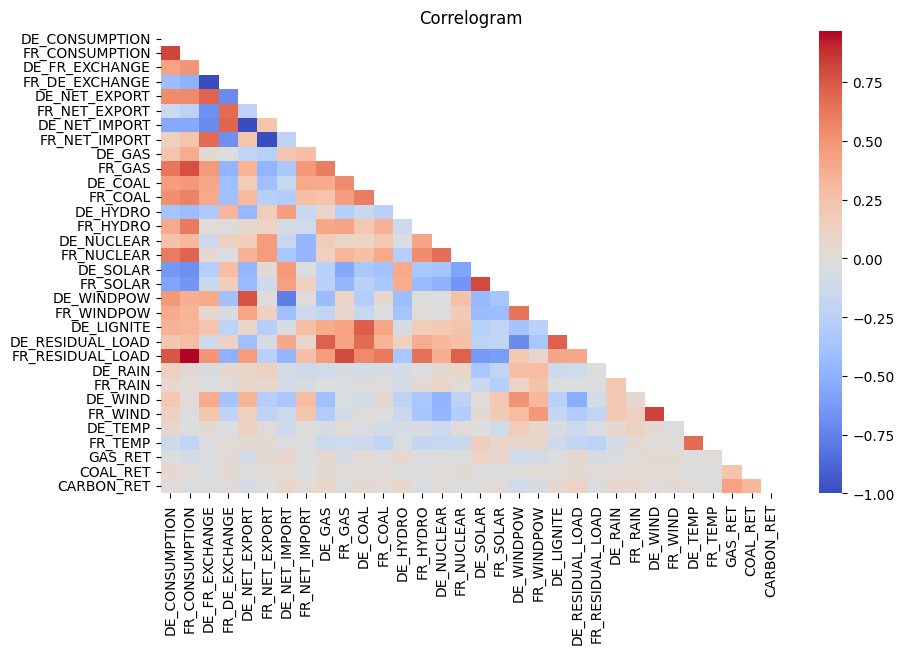

In [12]:
import seaborn as sns
import numpy as np

correlation_matrix = X_train.drop(columns=['COUNTRY','DAY_ID']).corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlogram')
plt.show()

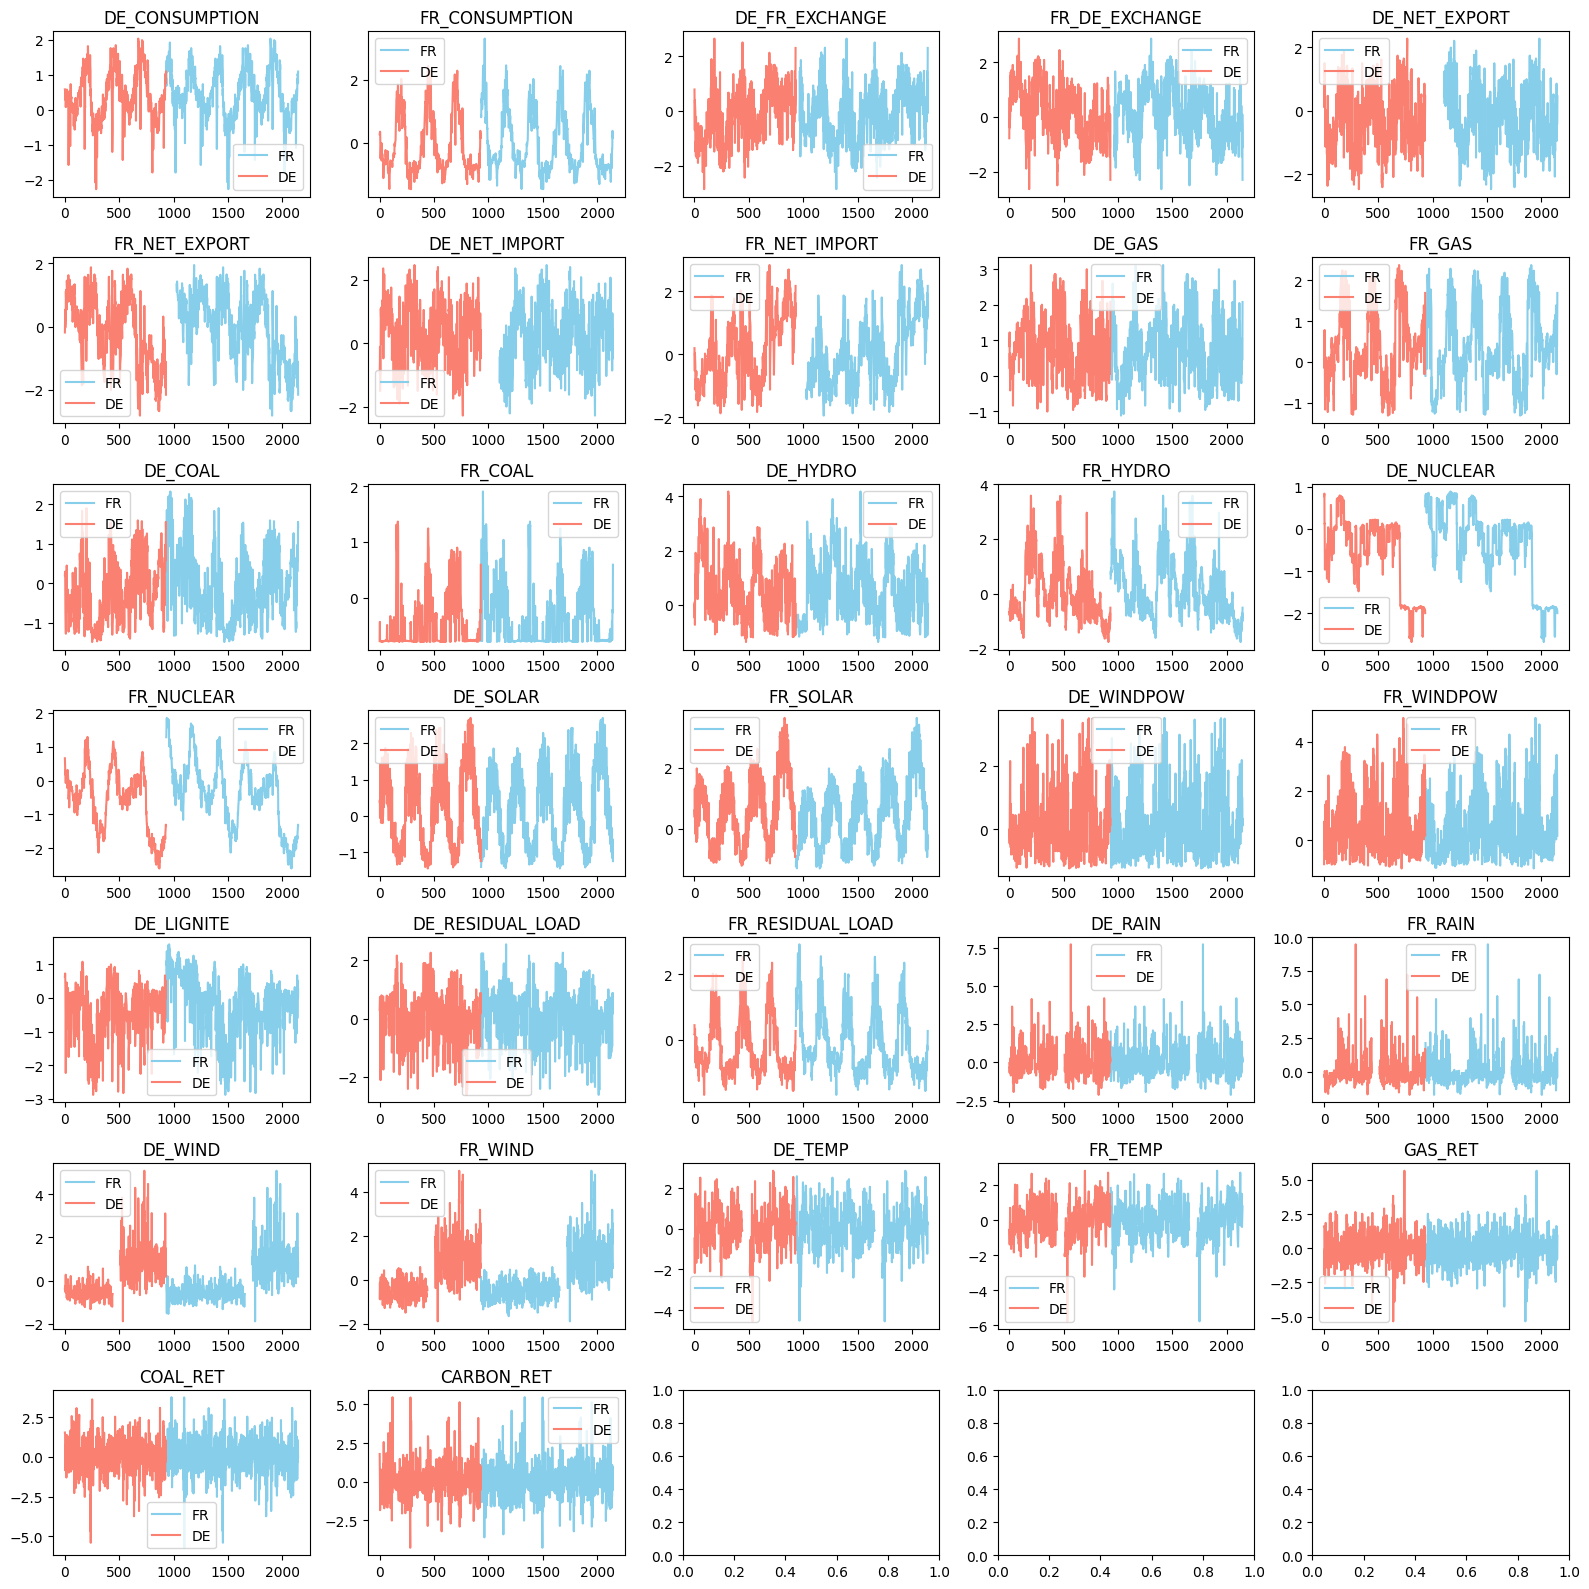

In [19]:
# Create fig and axes objects
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(16, 16))
axes = axes.flatten()
# List of column names in X_train
column_names = ['DE_CONSUMPTION', 'FR_CONSUMPTION',
       'DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT',
       'DE_NET_IMPORT', 'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL',
       'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR',
       'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE',
       'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND',
       'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET']

X_train['new_DAY_ID'] = X_train.index

# Iterate over each column
for i, current_column_name in enumerate(column_names):
    # Plot for 'FR' country
    ax = axes[i]
    fr_data = X_train[X_train.COUNTRY == 'FR'].sort_values(by=['new_DAY_ID'])[['new_DAY_ID', current_column_name]].to_numpy()
    ax.plot(fr_data[:, 0], fr_data[:, 1], label='FR', color='skyblue')

    # Plot for 'DE' country
    de_data = X_train[X_train.COUNTRY == 'DE'].sort_values(by=['new_DAY_ID'])[['new_DAY_ID', current_column_name]].to_numpy()
    ax.plot(de_data[:, 0], de_data[:, 1], label='DE', color='salmon')

    # Add title and labels
    ax.set_title(f'{current_column_name}')
    #ax.set_xlabel('DAY_ID')
    #ax.set_ylabel('Cumulative Sum')
    ax.legend()

plt.tight_layout()
# Show plot
plt.show()


**Daily commodity price variations:**

* GAS_RET: European gas,

* COAL_RET: European coal,

* CARBON_RET: Carbon emissions futures,


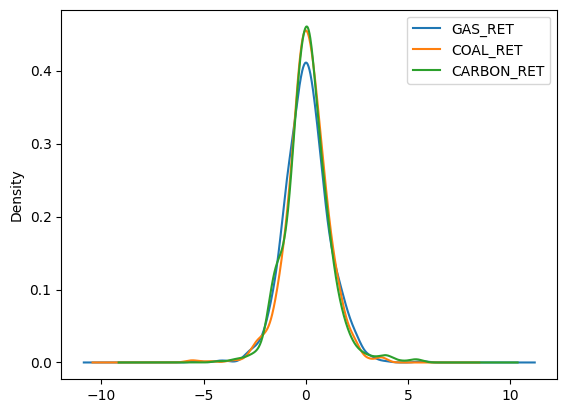

In [20]:
(X_train[X_train.COUNTRY=='FR'][['DAY_ID','GAS_RET','COAL_RET','CARBON_RET']].set_index('DAY_ID',drop=True).sort_index()).plot(kind='kde');

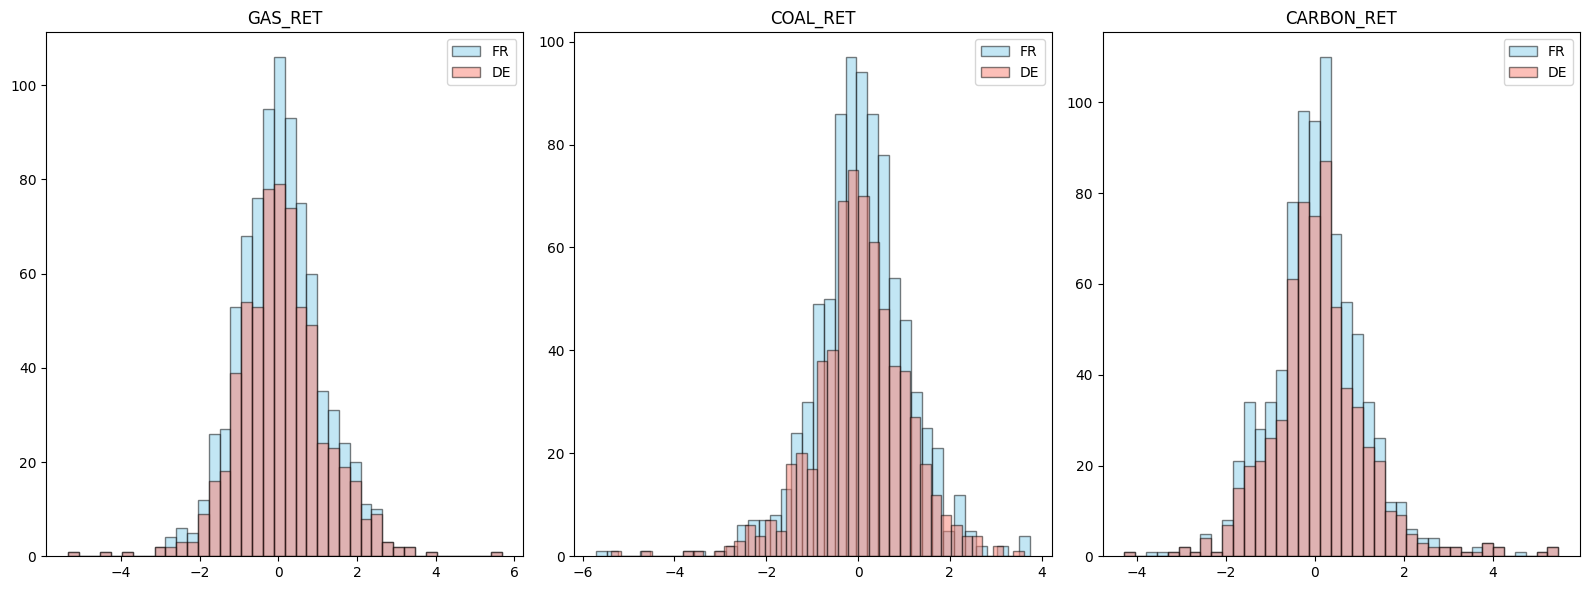

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
axes = axes.flatten()
# Filter dataset based on 'COUNTRY' column values
X_train_FR = X_train[X_train['COUNTRY'] == 'FR']
X_train_DE = X_train[X_train['COUNTRY'] == 'DE']
for i, column in enumerate(['GAS_RET','COAL_RET','CARBON_RET']):
    ax = axes[i]  # Select the current axis
    # Plot histogram for 'FR'
    ax.hist(X_train_FR[column], bins=40, color='skyblue', edgecolor='black', alpha=0.5, label='FR')
    # Plot histogram for 'DE'
    ax.hist(X_train_DE[column], bins=40, color='salmon', edgecolor='black', alpha=0.5, label='DE')
    ax.set_title(column)  # Set column name as title
    ax.legend()  # Add legend
plt.tight_layout()
#plt.suptitle('Feature Distributions (FR vs DE)')
plt.show()

**Weather Measures:** (daily, in the country x),

* x_TEMP: Temperature,

* x_RAIN: Rainfall,

* x_WIND: Wind,


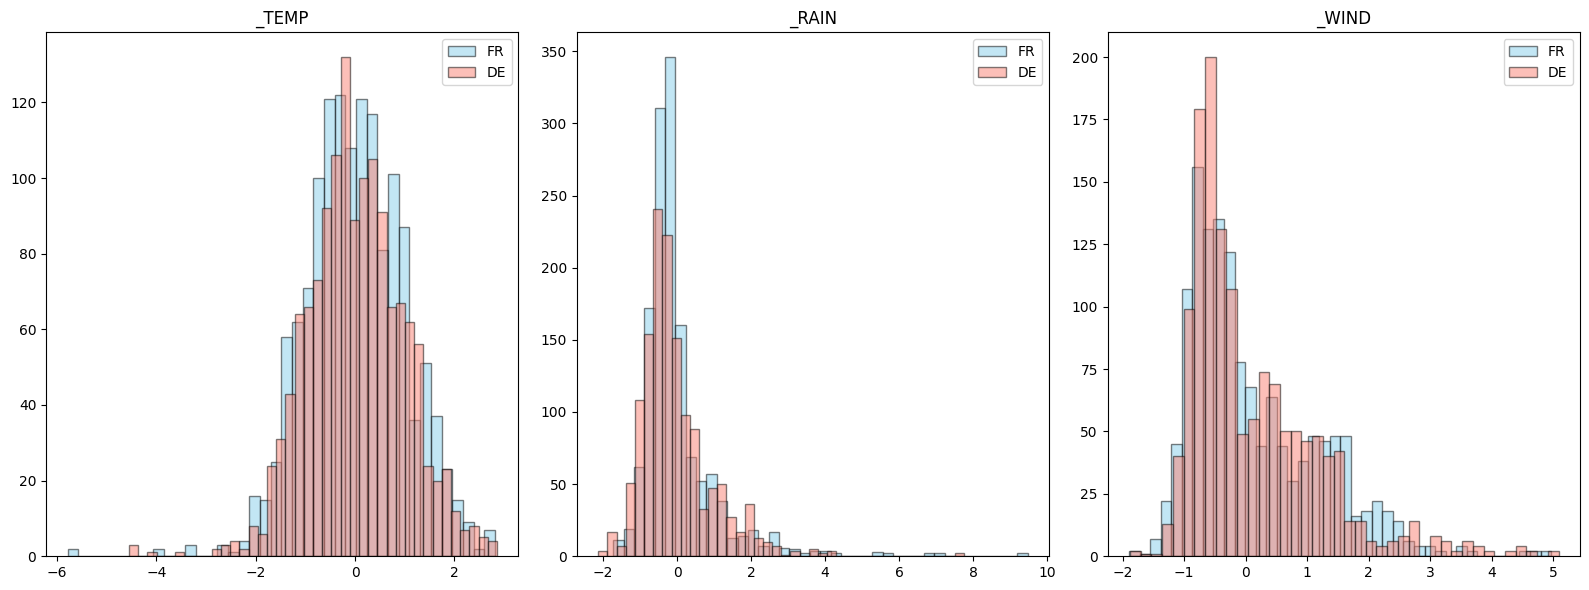

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
axes = axes.flatten()
for i, column in enumerate(['_TEMP','_RAIN','_WIND']):
    ax = axes[i]  # Select the current axis
    # Plot histogram for 'FR'
    ax.hist(X_train['FR'+column], bins=40, color='skyblue', edgecolor='black', alpha=0.5, label='FR')
    # Plot histogram for 'DE'
    ax.hist(X_train['DE'+column], bins=40, color='salmon', edgecolor='black', alpha=0.5, label='DE')
    ax.set_title(column)  # Set column name as title
    ax.legend()  # Add legend
plt.tight_layout()
#plt.suptitle('Feature Distributions (FR vs DE)')
plt.show()

**Energy production measures** (daily, in the country x),

* x_GAS: Natural gas,

* x_COAL: Hard coal,

* x_HYDRO: Hydro reservoir,

* x_NUCLEAR: Daily nuclear production,

* x_SOLAR: Photovoltaic,

* x_WINDPOW: Wind power,

* x_LIGNITE: Lignite,

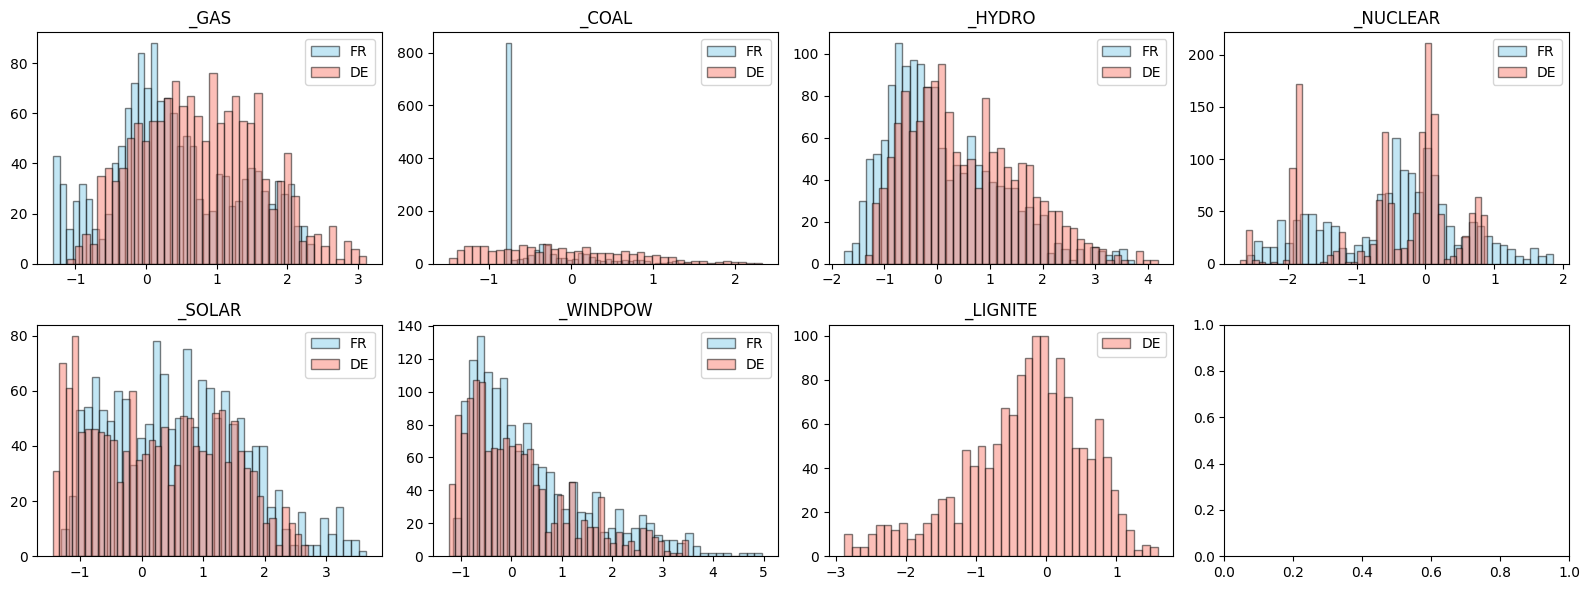

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6))
axes = axes.flatten()
for i, column in enumerate(['_GAS','_COAL','_HYDRO','_NUCLEAR','_SOLAR','_WINDPOW','_LIGNITE']):
    ax = axes[i]  # Select the current axis
    # Plot histogram for 'FR'
    if column != '_LIGNITE': ax.hist(X_train['FR'+column], bins=40, color='skyblue', edgecolor='black', alpha=0.5, label='FR')
    # Plot histogram for 'DE'
    ax.hist(X_train['DE'+column], bins=40, color='salmon', edgecolor='black', alpha=0.5, label='DE')
    ax.set_title(column)  # Set column name as title
    ax.legend()  # Add legend
plt.tight_layout()
#plt.suptitle('Feature Distributions (FR vs DE)')
plt.show()

**electricity use metrics** (daily, in the country x),

* x_CONSUMPTON: Total electricity consumption,

* x_RESIDUAL_LOAD: Electricity consumption after using all renewable energies,

* x_NET_IMPORT: Imported electricity from Europe,

* x_NET_EXPORT: Exported electricity to Europe,

* DE_FR_EXCHANGE: Total daily electricity exchange between Germany and France,

* FR_DE_EXCHANGE: Total daily electricity exchange between France and Germany.

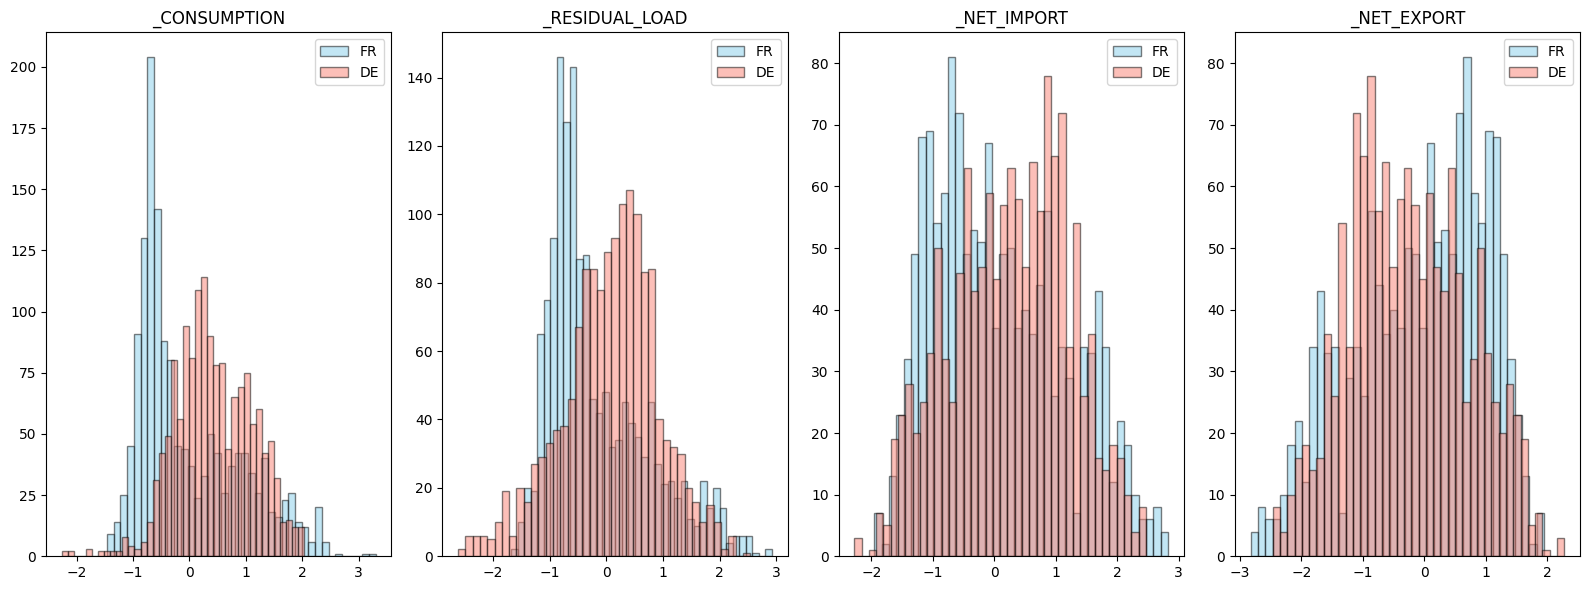

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 6))
axes = axes.flatten()
for i, column in enumerate(['_CONSUMPTION','_RESIDUAL_LOAD','_NET_IMPORT','_NET_EXPORT']):
    ax = axes[i]  # Select the current axis
    # Plot histogram for 'FR'
    ax.hist(X_train['FR'+column], bins=40, color='skyblue', edgecolor='black', alpha=0.5, label='FR')
    # Plot histogram for 'DE'
    ax.hist(X_train['DE'+column], bins=40, color='salmon', edgecolor='black', alpha=0.5, label='DE')
    ax.set_title(column)  # Set column name as title
    ax.legend()  # Add legend
plt.tight_layout()
#plt.suptitle('Feature Distributions (FR vs DE)')
plt.show()

## Comparing "DE" and "FR" feature distributions - Train + Test Set

In [26]:
# concat the trainset and testset || seperate the country to make comparision
true_test = pd.read_csv('X_test.csv').set_index('ID')
pd.set_option('display.max_columns', None)
de = X_train[X_train['COUNTRY'] == 'DE']
y_de = Y_train[Y_train.index.isin(de.index)]
fr = X_train[X_train['COUNTRY'] == 'FR']
y_fr = Y_train[Y_train.index.isin(fr.index)]

full = X_train.append(true_test).sort_index()
full_de = full[full['COUNTRY'] == 'DE']
full_fr = full[full['COUNTRY'] == 'FR']

# review the consumption metrics in Train + Test Set
full_use = full[['DE_CONSUMPTION', 'FR_CONSUMPTION',
       'DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT',
       'DE_NET_IMPORT', 'FR_NET_IMPORT','DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD']]

<ipython-input-26-c46323d94c6d>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full = X_train.append(true_test).sort_index()


### New Energy Structure

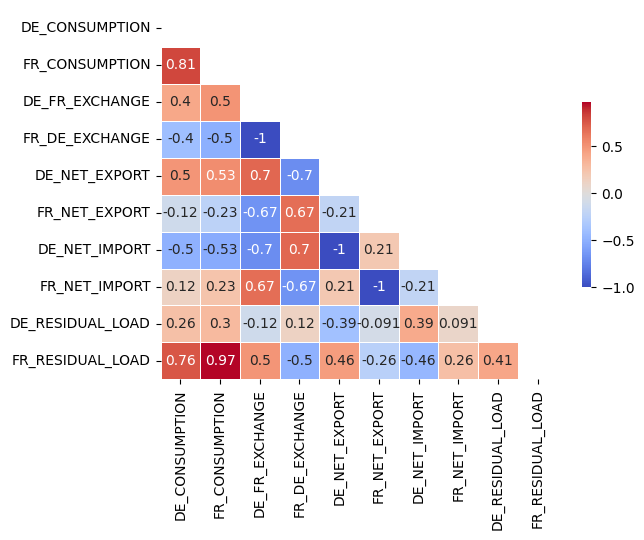

In [27]:
# heatmap
corr = full_use.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

**Note:**

Corr( FR_CONSUMPTION, FR_RESIDUAL_LOAD) = 0.97

Corr( DE_CONSUMPTION, DE_RESIDUAL_LOAD) = 0.26 !

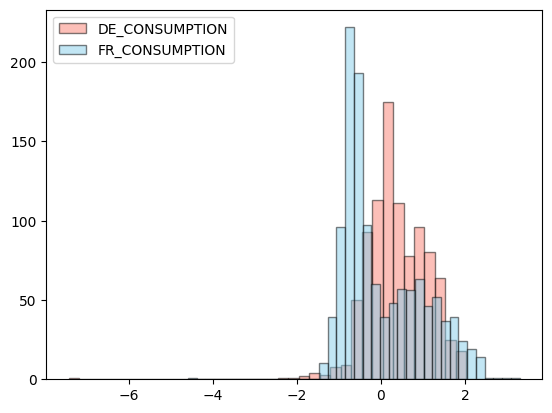

In [38]:
# 绘制层叠直方图
import matplotlib.pyplot as plt
import numpy as np

plt.hist(full_de_pqh['DE_CONSUMPTION'], bins=38, color='salmon', edgecolor='black', alpha=0.5, label='DE_CONSUMPTION')
plt.hist(full_fr_pqh['FR_CONSUMPTION'], bins=38, color='skyblue', edgecolor='black', alpha=0.5, label='FR_CONSUMPTION')

# 添加图例
plt.legend(loc='upper left')

# 显示图表
plt.show()

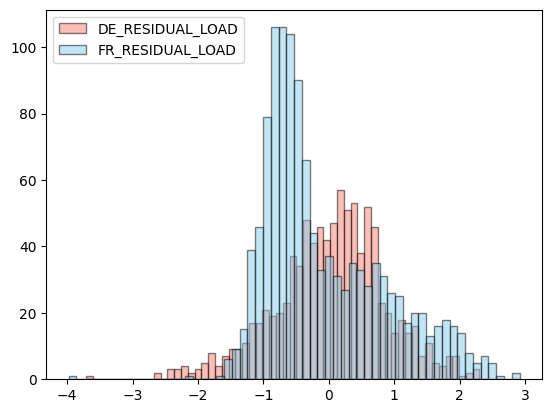

In [39]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(full_de_pqh['DE_RESIDUAL_LOAD'], color='salmon', edgecolor='black', bins=58, alpha=0.5, label='DE_RESIDUAL_LOAD')
plt.hist(full_fr_pqh['FR_RESIDUAL_LOAD'], color='skyblue', edgecolor='black', bins=58, alpha=0.5, label='FR_RESIDUAL_LOAD')

# 添加图例
plt.legend(loc='upper left')

# 显示图表
plt.show()

### Seasonal Trend

In [28]:
# choose the columns under my charge
col_list_de = ['DAY_ID','COUNTRY','DE_CONSUMPTION', 'DE_NET_EXPORT', 'DE_NET_IMPORT', 'DE_RESIDUAL_LOAD', 'DE_FR_EXCHANGE']
col_list_fr = ['DAY_ID','COUNTRY','FR_CONSUMPTION', 'FR_NET_EXPORT', 'FR_NET_IMPORT', 'FR_RESIDUAL_LOAD', 'FR_DE_EXCHANGE']
full_de_pqh = full_de[col_list_de]
full_fr_pqh = full_fr[col_list_fr]

<Figure size 640x480 with 0 Axes>

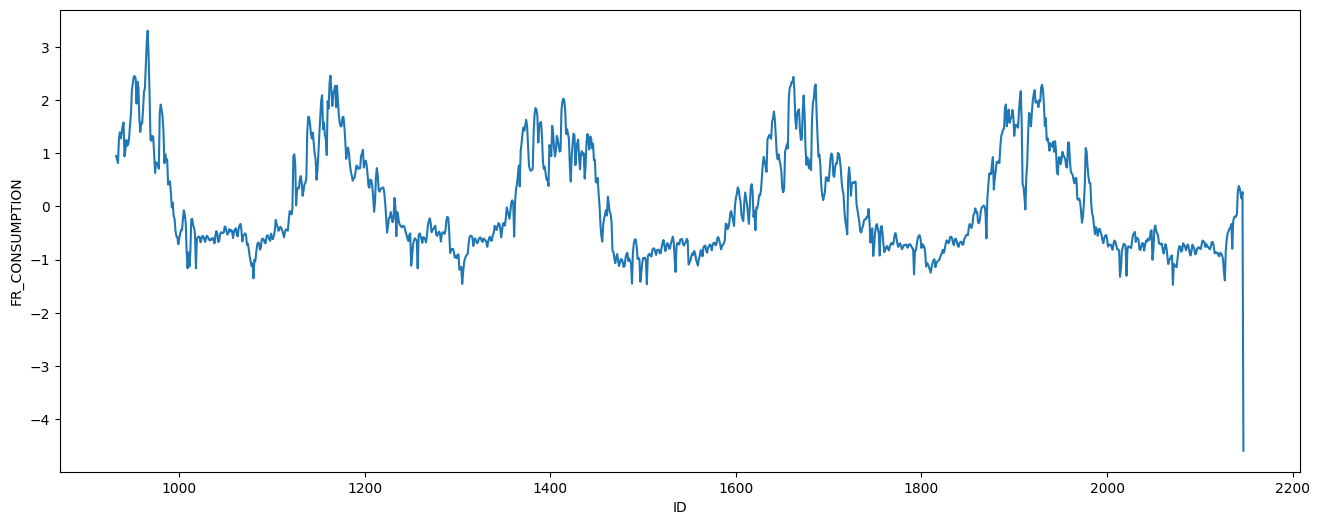

<Figure size 640x480 with 0 Axes>

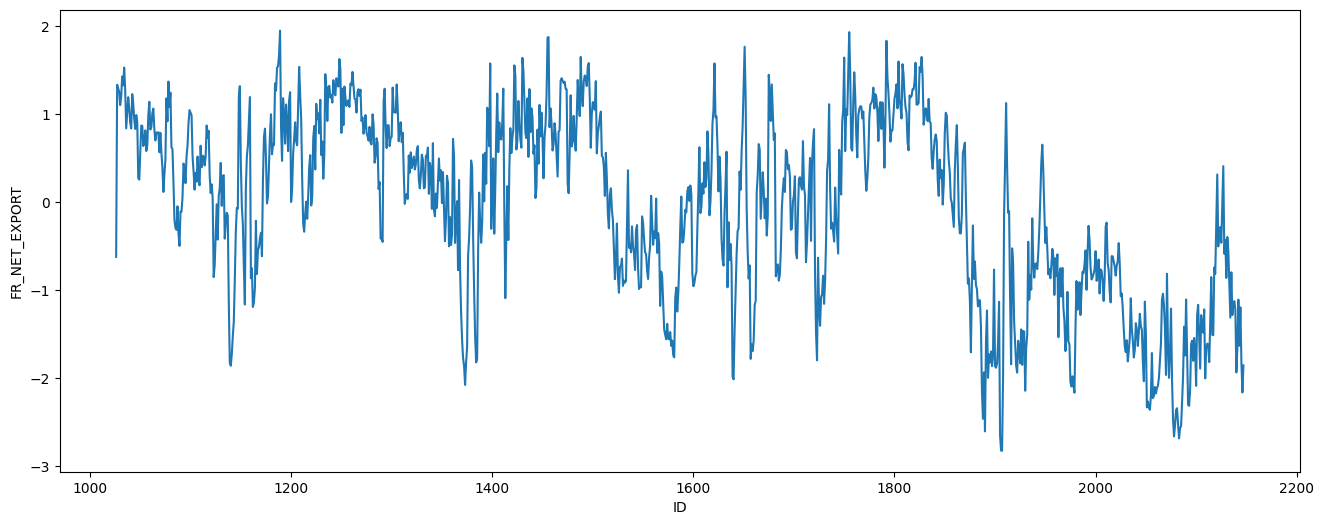

<Figure size 640x480 with 0 Axes>

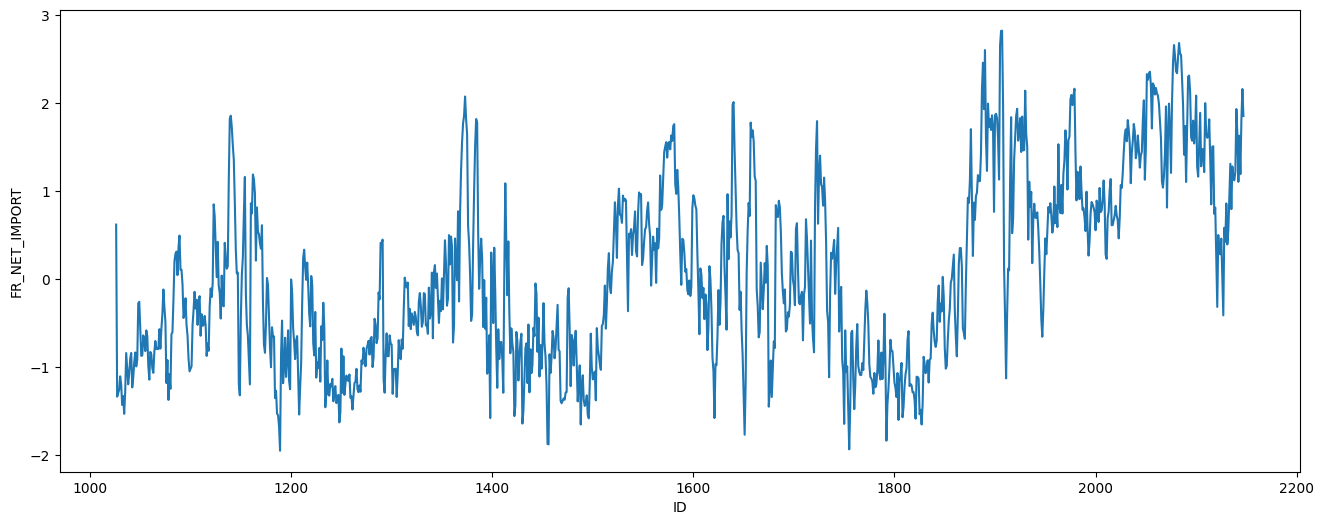

<Figure size 640x480 with 0 Axes>

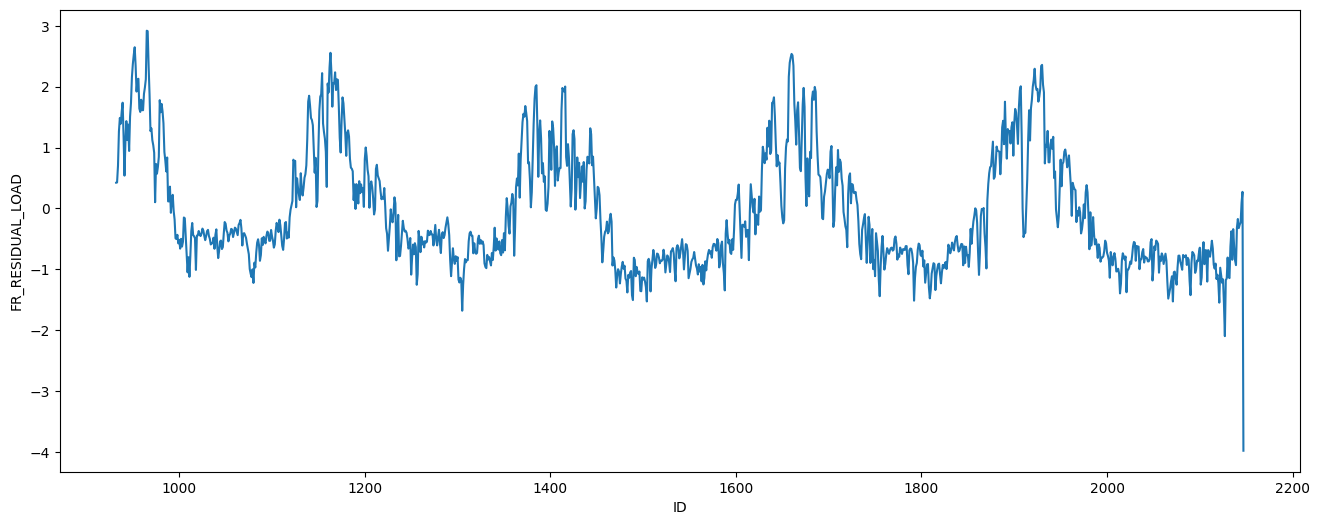

<Figure size 640x480 with 0 Axes>

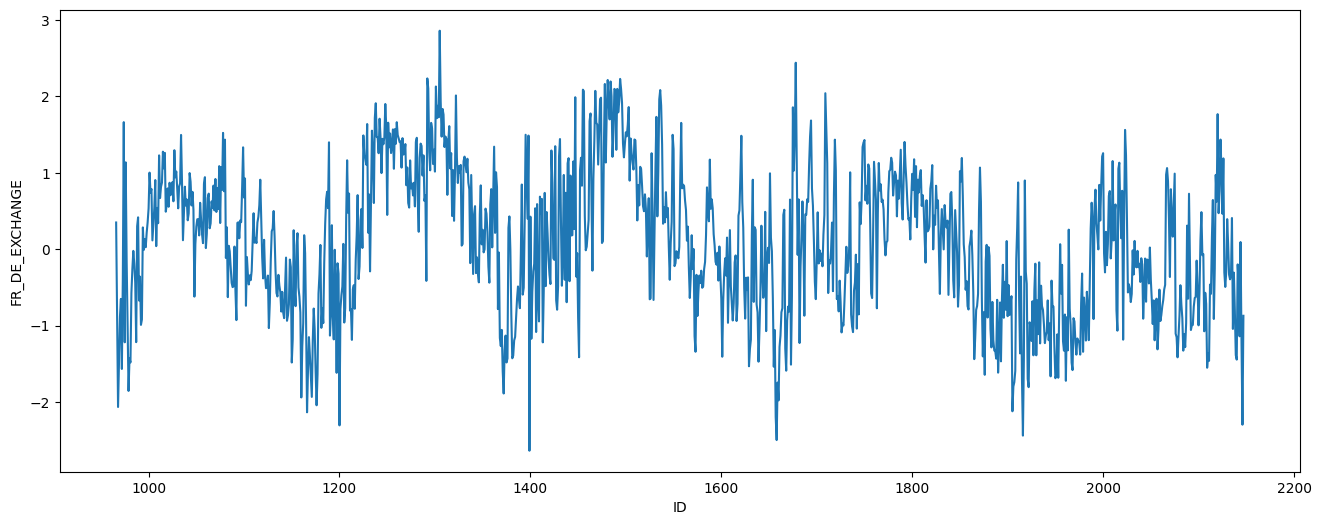

In [32]:
for col in full_fr_pqh.columns[2:]:
    plt.figure()
    fig, ax = plt.subplots(figsize=(16, 6))
    sns.lineplot(x=full_fr_pqh.index, y=full_fr_pqh[col])
    plt.show()

### Null Value Details

In [34]:
full_de_pqh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 932 entries, 0 to 931
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DAY_ID            932 non-null    int64  
 1   COUNTRY           932 non-null    object 
 2   DE_CONSUMPTION    932 non-null    float64
 3   DE_NET_EXPORT     932 non-null    float64
 4   DE_NET_IMPORT     932 non-null    float64
 5   DE_RESIDUAL_LOAD  932 non-null    float64
 6   DE_FR_EXCHANGE    932 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 58.2+ KB


In [35]:
full_fr_pqh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1216 entries, 932 to 2147
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DAY_ID            1216 non-null   int64  
 1   COUNTRY           1216 non-null   object 
 2   FR_CONSUMPTION    1216 non-null   float64
 3   FR_NET_EXPORT     1122 non-null   float64
 4   FR_NET_IMPORT     1122 non-null   float64
 5   FR_RESIDUAL_LOAD  1216 non-null   float64
 6   FR_DE_EXCHANGE    1182 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 76.0+ KB


**Note:**

only FR has null values, in continues time period

FR_NET_EX/IMPORT: 94 NULL

FR_DE_EXCHANGE: 34 NULL
